In [1]:
## Importing shapefile to read the shapefile files
import shapefile
# Other imports 
import time
from time import sleep
import simpledbf 
from simpledbf import Dbf5
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
import matplotlib as mpl
from datetime import datetime

SQLalchemy is not installed. No support for SQL output.


In [45]:
# Creates a new .shp file with only the country entries that you specified
# WARNING: Takes a long time to run
def filter_by_country(fires_data, country, month, gmaps, max_iterations = 10000):
    fireIds = set()
    w = shapefile.Writer('{filter_country}_fires_{filter_month}_2020.shp'.format(filter_country = country, filter_month = month))
    w.fields = fires_data.fields[1:]
    # valid_id tracks whether the last read unique id was valid for our country
    valid_id = False
    # Iterate through all shapeRecords for global dataset
    counter = 1
    starting_time = time.time()
    fire_data_shape_records = fires_data.shapeRecords()
    randomShapeRecords = random.sample(range(len(fire_data_shape_records)), max_iterations)
    adding_count = 0
    for shapeRecordIndex in randomShapeRecords:
        shapeRecord = fire_data_shape_records[shapeRecordIndex]
        # Get the fire ID
        fireId = shapeRecord.record[2]
       
        # If the fireId is not in the country and already read, we go to the next fireID
        if fireId in fireIds:
            continue
        # If the fireId is not in the country and not yet read, we add it, say it's not in the country (for now)
        # and find its latitude and longitude
        else:
            fireIds.add(fireId)
            goodId = False
            
        # if it got past above, gets the points latitudes and longitudes

        fireLatLong = shapeRecord.shape.points[0][::-1]
        
        
        if counter % 100 == 0:
            print("Count: ", counter)
            print("Time Passed: ", time.time() - starting_time, " seconds")
        counter += 1

        #try/except is a cheat for now

        # Gets the readable results
        try: 
            results = gmaps.reverse_geocode(fireLatLong)[1]
            address_dicts = results['address_components']
            # Find the address_dict that details the country and get the country name 
            for address_dict in address_dicts:
                if address_dict['types'][0] == 'country':
                    long_name = address_dict['long_name']
                    break
           
            # If it is the right country, add it to our dataset!
            if long_name.lower() == country.lower():
                goodId = fireId
                earlier_index = shapeRecordIndex - 1
                later_index = shapeRecordIndex + 1 
                shapeEntryBefore = fire_data_shape_records[earlier_index]
                w.record(*shapeRecord.record)
                w.shape(shapeRecord.shape) 
                adding_count += 1
                while shapeEntryBefore.record[2] == fireId:
                    w.record(*shapeEntryBefore.record)
                    w.shape(shapeEntryBefore.shape) 
                    earlier_index -= 1
                    shapeEntryBefore = fire_data_shape_records[earlier_index]
                    adding_count += 1

                shapeEntryAfter = fire_data_shape_records[later_index]

                while shapeEntryAfter.record[2] == fireId:
                    w.record(*shapeEntryBefore.record)
                    w.shape(shapeEntryBefore.shape) 
                    later_index += 1
                    shapeEntryAfter = fire_data_shape_records[later_index]
                    adding_count += 1
                
                print("We've now added ", adding_count, " entries")

                
                
        except Exception as e:
            print("Error: ")
            print(results)
    print("FINAL Time Passed: ", time.time() - starting_time, " seconds")
    w.close()     

# Returns a database with only certain Id entries
def sort_by_id(df,eyeD):
    # Get data for just one fire
    sorted_id = df.loc[df['Id'] == eyeD]
    sorted_id = sorted_id.sort_values(by='IDate')
    return sorted_id
    

    
def plotPolygons(oldBurnIndexArrays, newBurnIndexArray, date, figureIndex):
    fig = plt.figure(figureIndex)
    ax = fig.add_subplot(111)
    polygon_array = []
    for polygon_indices in oldBurnIndexArrays:
        coll = PolyCollection(polygon_indices, cmap=mpl.cm.jet, edgecolors='none')
        ax.add_collection(coll)
        coll.set_color([.5, .1, .1])
        ax.autoscale_view()
    coll = PolyCollection(newBurnIndexArray, cmap=mpl.cm.jet, edgecolors='none')
    ax.add_collection(coll)
    coll.set_color([1, 0, 0])
    ax.autoscale_view()
    ax.set_facecolor('darkgreen')

    plt.title("Active burn on: {:%m/%d/%Y}".format(date))
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
        
    
def dayToDayProgression(df, eyeD, shapeRecords):
    # Detailing the day to day progression of a fire
    # It looks like some dates have better data than others, which is interesting. General trends look okay though for a first go around! 
    ID_df = sort_by_id(df,eyeD)

    lastFDate = None
    min_max_day = [float('inf'), float('inf'), -float('inf'), -float('inf')]
    day_index = 2 
    polygon_date_array = []
    polygon_date_dict = {}
    print(ID_df)
    for row in ID_df.iterrows():
        feature = shapeRecords[row[0]]

        if row[1]['FDate'] == lastFDate:
            polygon_date_array.append(feature.shape.points) 

        else:
            lastFDate = row[1]['FDate']
            if len(polygon_date_array) == 0:
                continue
            polygon_date_dict[row[1]['FDate']] = polygon_date_array
            polygon_date_array = []

    polygon_date_dict[row[1]['FDate']] = polygon_date_array

    
    fig = plt.figure(day_index)
    ax = fig.add_subplot(111)
    polygon_array = []
    day_index = 1
    for date, polygon_indices in polygon_date_dict.items():
        print(date)
        if day_index < 4:
            day_index += 1
            continue
        polygon_indices = polygon_date_dict[date]
        plotPolygons(polygon_array, polygon_indices, date, day_index)
        polygon_array.append(polygon_indices)
        day_index += 1

In [26]:
# Read in all the shapes for file perimeters from December 2020
shape = shapefile.Reader("./../data/United_States_2020_Fires/1_January/United_States_fires_jan_2020.shp")
shapeRecords = shape.shapeRecords()

In [27]:
dbf = Dbf5('./../data/United_States_2020_Fires/1_January/United_States_fires_jan_2020.dbf')
df = dbf.to_dataframe()

           IDate        Type        Id       FDate
5514  2020-08-17   FinalArea  23582291  2020-10-13
5421  2020-08-17   FinalArea  23582291  2020-10-13
5420  2020-08-17   FinalArea  23582291  2020-10-13
5419  2020-08-17   FinalArea  23582291  2020-10-13
5418  2020-08-17   FinalArea  23582291  2020-10-13
...          ...         ...       ...         ...
510   2020-09-29  ActiveArea  23582291  2020-09-29
551   2020-09-30  ActiveArea  23582291  2020-09-30
610   2020-09-30  ActiveArea  23582291  2020-09-30
550   2020-09-30  ActiveArea  23582291  2020-09-30
583   2020-09-30  ActiveArea  23582291  2020-09-30

[1074 rows x 4 columns]
2020-08-17
2020-10-13
2020-08-18
2020-08-19
2020-08-20
2020-08-21
2020-08-22
2020-08-23
2020-08-24
2020-08-25
2020-08-26
2020-08-27
2020-08-28
2020-08-29
2020-08-30
2020-08-31
2020-09-01
2020-09-02
2020-09-03
2020-09-04
2020-09-05
2020-09-06
2020-09-07
2020-09-08
2020-09-09


C:\Users\nico\AppData\Local\Temp/ipykernel_33704/1212071048.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figureIndex)


2020-09-10
2020-09-11
2020-09-12
2020-09-13
2020-09-14
2020-09-15
2020-09-16
2020-09-17
2020-09-18
2020-09-19
2020-09-20
2020-09-21
2020-09-22
2020-09-23
2020-09-24
2020-09-25
2020-09-26
2020-09-27
2020-09-28
2020-09-29
2020-09-30


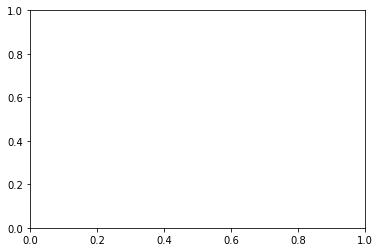

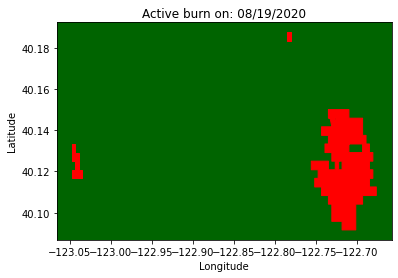

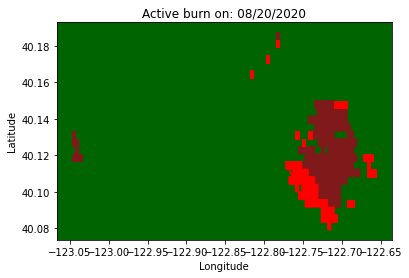

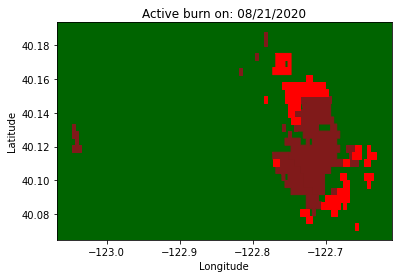

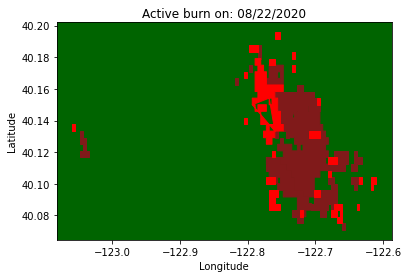

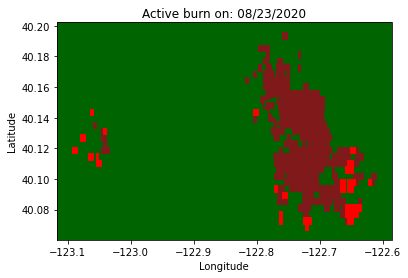

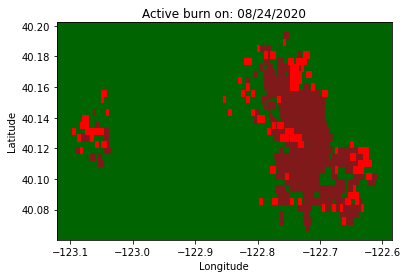

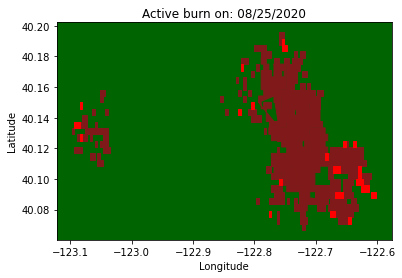

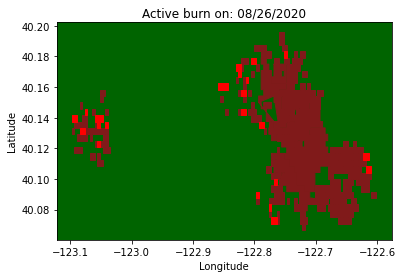

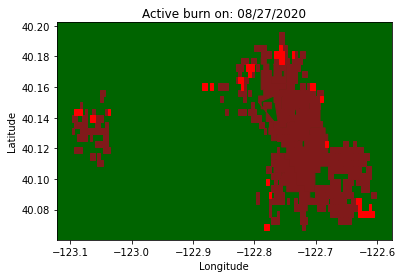

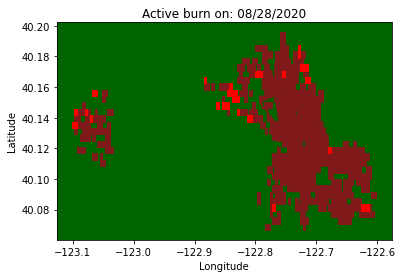

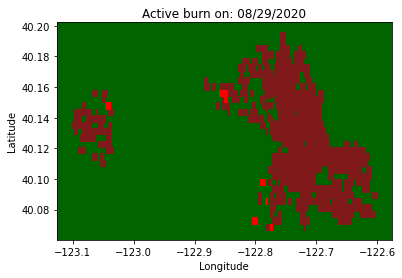

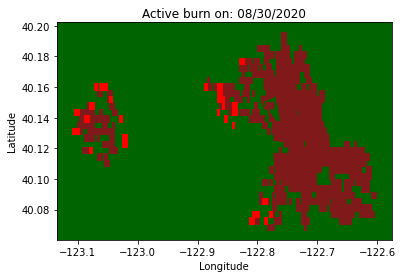

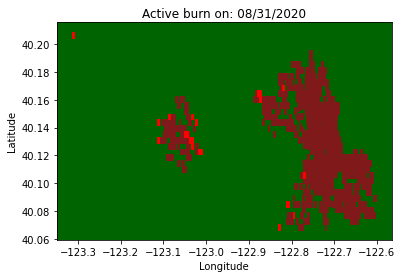

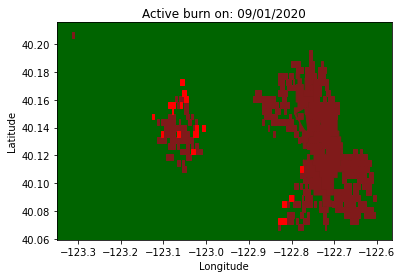

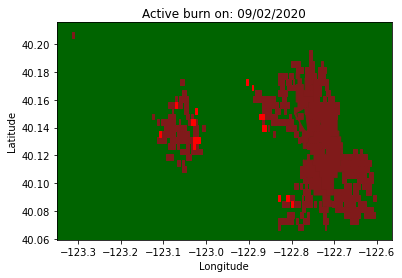

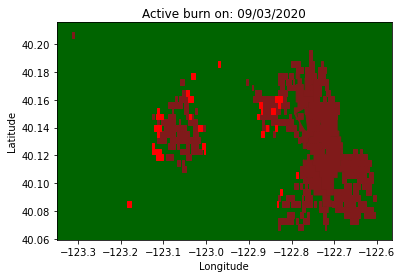

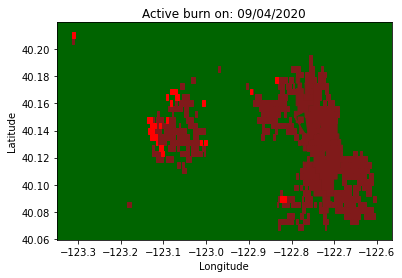

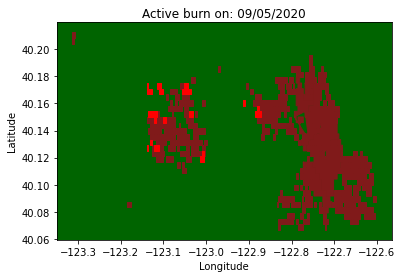

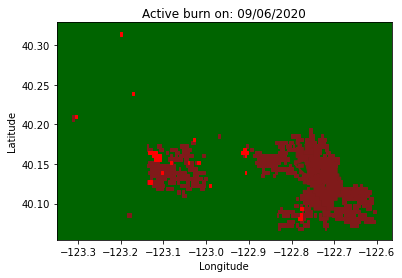

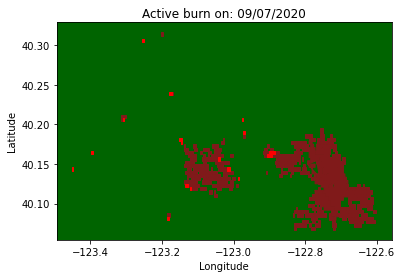

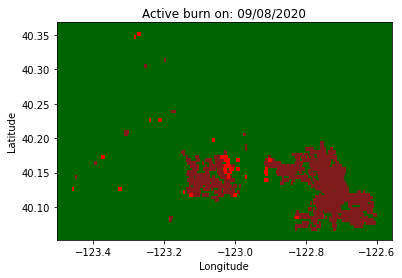

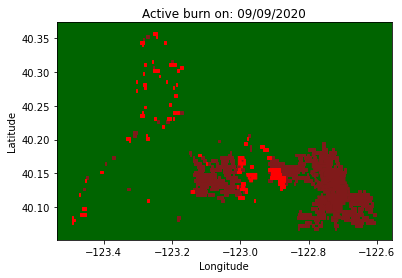

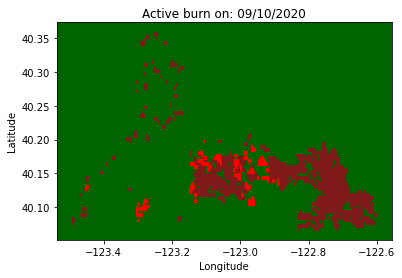

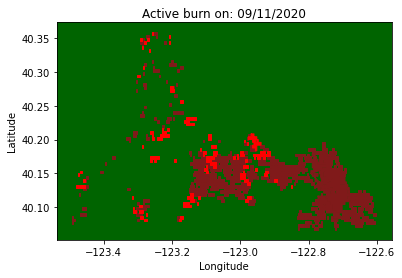

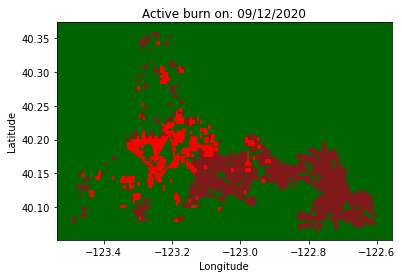

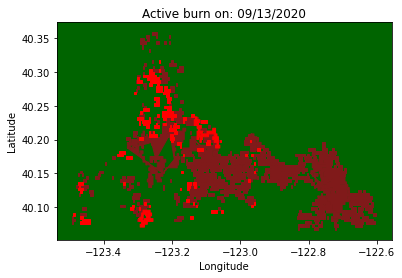

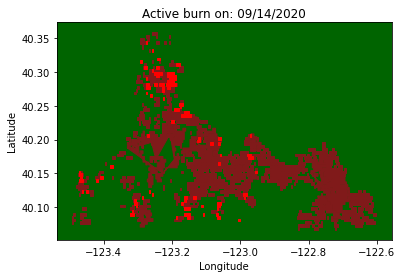

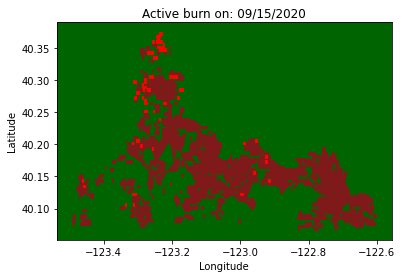

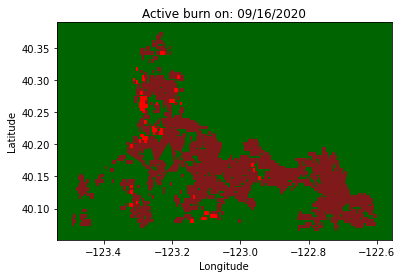

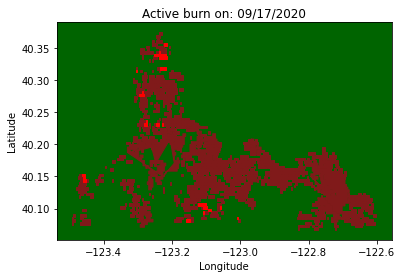

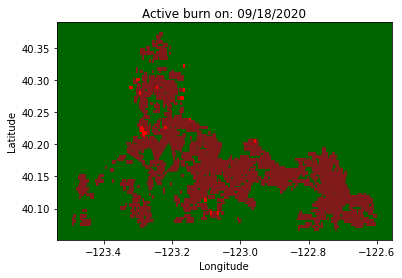

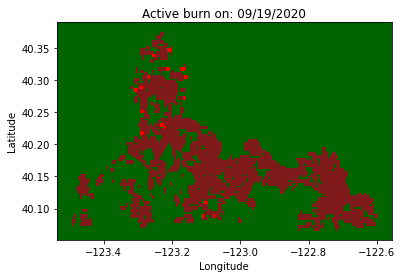

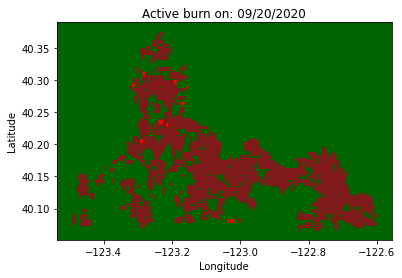

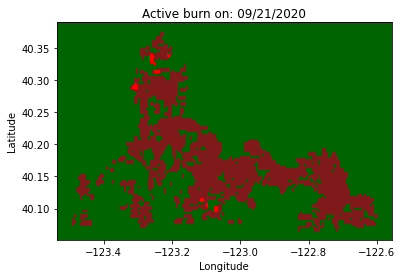

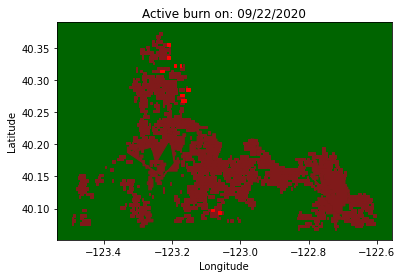

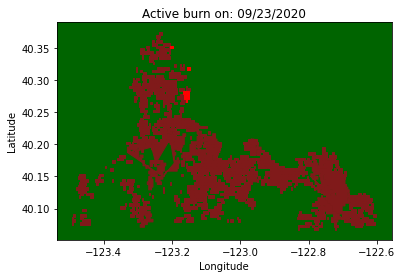

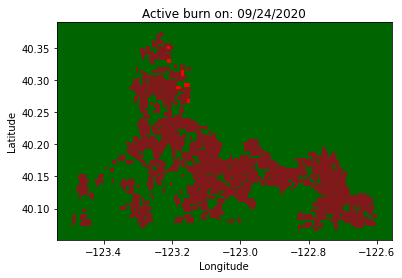

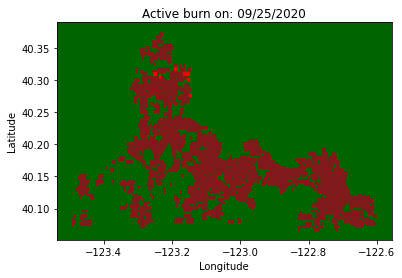

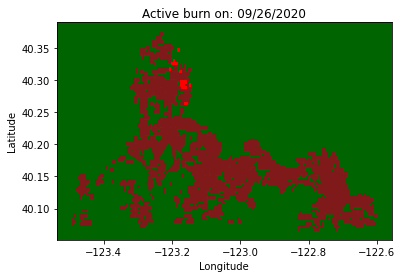

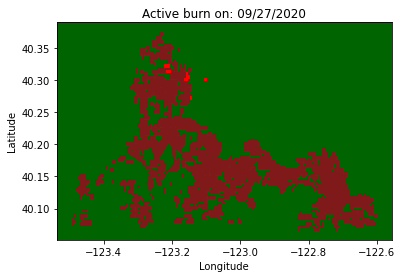

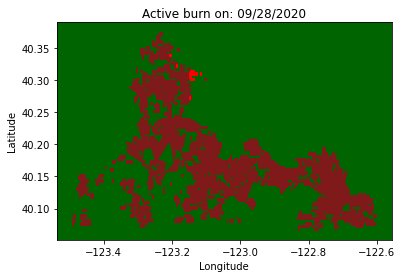

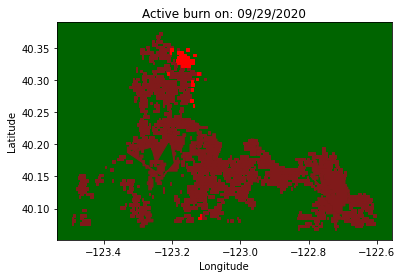

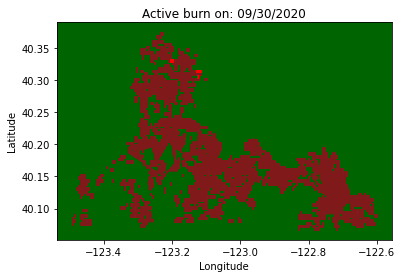

In [47]:
parameter = 0 # change this however you want
fire_ID = shapeRecords[parameter].record[2]
dayToDayProgression(df, fire_ID, shapeRecords)